In [1]:
import numpy as np
import matplotlib.pyplot as plt
from TidalPy.RadialSolver import radial_solver as radial_solver_new
from TidalPy.radial_solver import radial_solver as radial_solver_old
from TidalPy.utilities.graphics.multilayer import yplot
from TidalPy.rheology.models import Maxwell, Andrade, Elastic
from TidalPy.utilities.spherical_helper import calculate_mass_gravity_arrays

## 1 Layer

2024-04-26 15:24:11(+00:00:06::674141) - WARNING  : Dynamic liquid layer detected in RadialSolver for a small frequency. Results may be unstable. Extra care is advised!
C:\Users\joepr\anaconda3\envs\dev311\Lib\site-packages\numba\core\ir_utils.py:2149: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'gravity_at_interfaces' of function 'collapse_solutions'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "C:\Users\joepr\anaconda3\envs\dev311\Lib\site-packages\TidalPy\radial_solver\numerical\collapse\generalized_collapse.py", line 23:
@njit(cacheable=True)
def collapse_solutions(
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
C:\Users\joepr\anaconda3\envs\dev311\Lib\site-packages\numba\core\ir_utils.py:2149: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is sch

Old size: (6, 100); new: (6, 100).


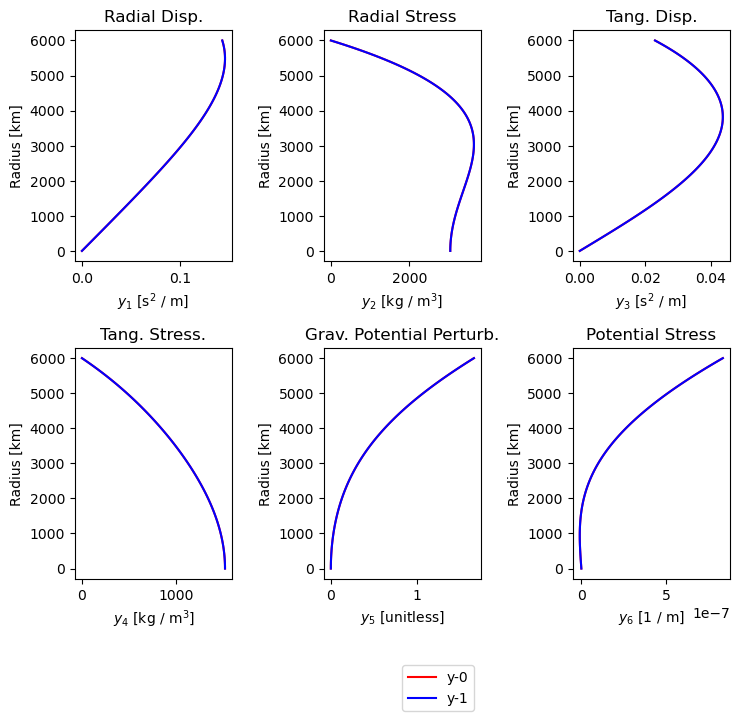

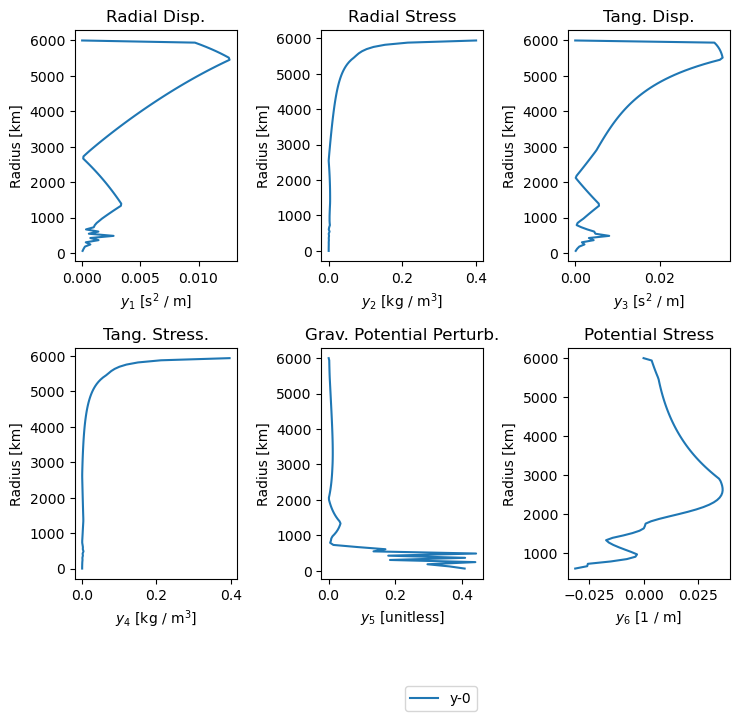

0j


In [2]:
def test_1layer():
    frequency = np.pi * 2. / (86400. * 7.5)
    
    radius_array = np.linspace(0.1, 6000.0e3, 100)
    indices_by_layer = radius_array > 0.
    density_array = np.ones_like(radius_array) * 5400.
    planet_bulk_density = np.average(density_array)
    bulk_modulus_array = np.ones_like(radius_array) * 1.0e11
    shear_array = np.ones_like(radius_array) * 50.0e9
    viscosity_array = np.ones_like(radius_array) * 1.0e18

    rheo_inst = Andrade()
    complex_shear_modulus_array = np.empty(radius_array.size, dtype=np.complex128)
    rheo_inst.vectorize_modulus_viscosity(frequency, shear_array, viscosity_array, complex_shear_modulus_array)
    
    volume_array, mass_array, gravity_array = \
        calculate_mass_gravity_arrays(radius_array, density_array)
    
    input_new_dict = dict(
        radius_array=radius_array,
        density_array=density_array,
        gravity_array=gravity_array,
        bulk_modulus_array=bulk_modulus_array,
        complex_shear_modulus_array=complex_shear_modulus_array,
        frequency=frequency,
        planet_bulk_density=planet_bulk_density,
        layer_types=('solid',),
        is_static_by_layer=(False,),
        is_incompressible_by_layer=(False,),
        upper_radius_by_layer=(radius_array[-1],),
        degree_l = 2,
        solve_for = None,
        use_kamata = False,
        integration_method = 'DOP853',
        integration_rtol = 1.0e-9,
        integration_atol = 1.0e-12,
        scale_rtols_by_layer_type = False,
        max_num_steps = 500_000,
        expected_size = 500,
        max_ram_MB = 500,
        max_step = 0,
        limit_solution_to_radius = True,
        nondimensionalize = False,
        verbose = False,
        raise_on_fail = False,     
    )

    input_old_dict = dict(        
        radius=radius_array,
        density=density_array,
        gravity=gravity_array,
        bulk_modulus=bulk_modulus_array,
        shear_modulus=complex_shear_modulus_array,
        frequency=frequency,
        planet_bulk_density=planet_bulk_density,
        is_solid_by_layer=(True,),
        is_static_by_layer=(False,),
        indices_by_layer=(indices_by_layer,),
        order_l = 2,
        surface_boundary_condition=None, 
        solve_load_numbers=False,
        use_kamata = False,
        integration_method = 'DOP853',
        integrator = 'scipy',
        integration_rtol = 1.0e-9,
        integration_atol = 1.0e-12,
        nondimensionalize = False,
        verbose = False,
        incompressible = False,        
    )

    new_result = radial_solver_new(**input_new_dict)
    old_ys = radial_solver_old(**input_old_dict)

    new_ys = new_result.result

    print(f'Old size: {old_ys.shape}; new: {new_ys.shape}.')
    yplot([old_ys, new_ys], [radius_array, radius_array], colors=['r', 'b'])
    
    percent_diff = 200 * np.abs(old_ys - new_ys) / (old_ys + new_ys)
    percent_diff[np.logical_and(np.isclose(old_ys, 0. + 0.j), np.isclose(new_ys, 0. + 0.j))] = np.nan
    yplot([percent_diff], [radius_array])

    print(new_ys[1, -1])

test_1layer()

# 2 Layers

Old size: (6, 100); new: (6, 100).


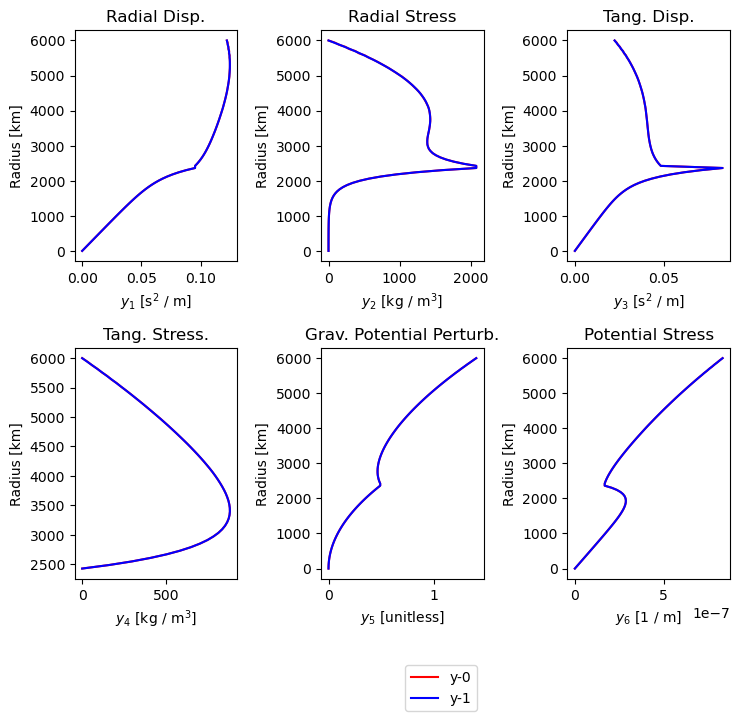

C:\Users\joepr\AppData\Local\Temp\ipykernel_13976\1364903349.py:100: RuntimeWarning: invalid value encountered in divide
  percent_diff = 200 * np.abs(old_ys - new_ys) / (old_ys + new_ys)


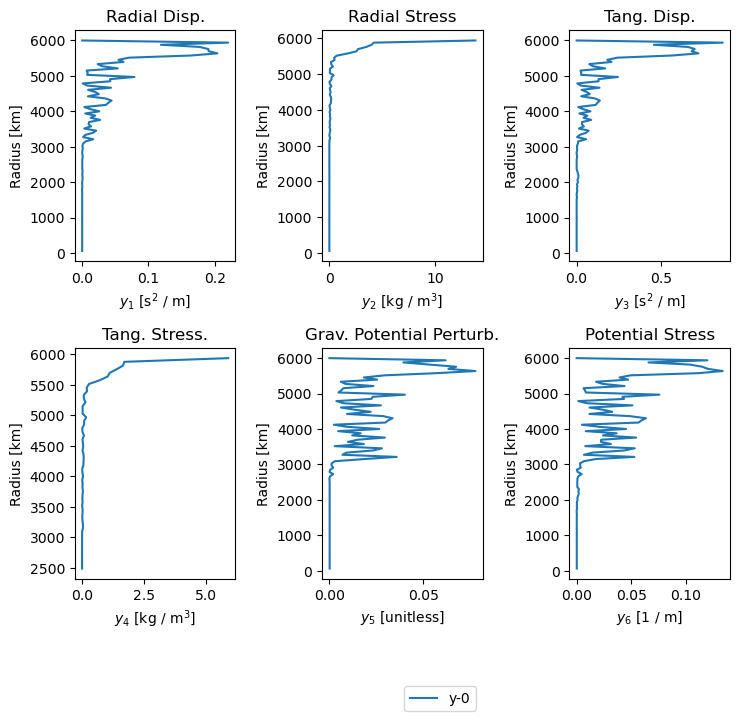

(2.886579864025407e-12-4.5102810375396984e-14j)


In [30]:
def test_2layer():
    layer_types = ('liquid', 'solid')
    is_solid_by_layer = (False, True)
    is_static_by_layer = (False, False)
    integration_method = 'RK45'
    integration_rtol = 1.0e-8
    integration_atol = 1.0e-10
    nondimensionalize = True
    is_incompressible_by_layer = (False, False)
    use_kamata = False
    
    radius_array = np.linspace(0.1, 6000.0e3, 100)
    CMB_radius = 0.4 * radius_array[-1]
    upper_radius_by_layer = (CMB_radius, radius_array[-1])
    
    frequency = np.pi * 2. / (86400. * 0.3)
    
    ic_index = radius_array <= CMB_radius
    mantle_index = radius_array > CMB_radius
    
    indices_by_layer = (ic_index, mantle_index)
    density_array = np.ones_like(radius_array) * 3500.
    density_array[ic_index] = 11000.
    planet_bulk_density = np.average(density_array)
    bulk_modulus_array = np.ones_like(radius_array) * 1.0e11
    bulk_modulus_array[ic_index] = 5.0e11
    shear_array = np.ones_like(radius_array) * 50.0e9
    shear_array[ic_index] = 0.
    viscosity_array = np.ones_like(radius_array) * 1.0e18
    viscosity_array[ic_index] = 1000.

    rheo_inst = Andrade()
    complex_shear_modulus_array = np.empty(radius_array.size, dtype=np.complex128)
    rheo_inst.vectorize_modulus_viscosity(frequency, shear_array, viscosity_array, complex_shear_modulus_array)
    
    volume_array, mass_array, gravity_array = \
        calculate_mass_gravity_arrays(radius_array, density_array)
    
    input_new_dict = dict(
        radius_array=radius_array,
        density_array=density_array,
        gravity_array=gravity_array,
        bulk_modulus_array=bulk_modulus_array,
        complex_shear_modulus_array=complex_shear_modulus_array,
        frequency=frequency,
        planet_bulk_density=planet_bulk_density,
        layer_types=layer_types,
        is_static_by_layer=is_static_by_layer,
        is_incompressible_by_layer=is_incompressible_by_layer,
        upper_radius_by_layer=upper_radius_by_layer,
        degree_l = 2,
        solve_for = None,
        use_kamata = use_kamata,
        integration_method = integration_method,
        integration_rtol = integration_rtol,
        integration_atol = integration_atol,
        scale_rtols_by_layer_type = False,
        max_num_steps = 5_000_000,
        expected_size = 1000,
        max_ram_MB = 3000,
        max_step = 0,
        limit_solution_to_radius = True,
        nondimensionalize = nondimensionalize,
        verbose = False,
        raise_on_fail = False,     
    )

    input_old_dict = dict(        
        radius=radius_array,
        density=density_array,
        gravity=gravity_array,
        bulk_modulus=bulk_modulus_array,
        shear_modulus=complex_shear_modulus_array,
        frequency=frequency,
        planet_bulk_density=planet_bulk_density,
        is_solid_by_layer=is_solid_by_layer,
        is_static_by_layer=is_static_by_layer,
        indices_by_layer=indices_by_layer,
        order_l = 2,
        surface_boundary_condition=None, 
        solve_load_numbers=False,
        use_kamata = use_kamata,
        integration_method = integration_method,
        integrator = 'cyrk',
        integration_rtol = integration_rtol,
        integration_atol = integration_atol,
        nondimensionalize = nondimensionalize,
        verbose = False,
        incompressible = False,        
    )

    new_result = radial_solver_new(**input_new_dict)
    old_ys = radial_solver_old(**input_old_dict)

    new_ys = new_result.result

    print(f'Old size: {old_ys.shape}; new: {new_ys.shape}.')
    yplot([old_ys, new_ys], [radius_array, radius_array], colors=['r', 'b'])
    
    percent_diff = 200 * np.abs(old_ys - new_ys) / (old_ys + new_ys)
    percent_diff[np.logical_and(np.isclose(old_ys, 0. + 0.j), np.isclose(new_ys, 0. + 0.j))] = np.nan
    yplot([percent_diff], [radius_array])

    print(new_ys[1, -1])

test_2layer()

## 3 Layers

[0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j
 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j
 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j
 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j
 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j
 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j
 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j
 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j
 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j
 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j
 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j
 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j
 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j
 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j
 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00

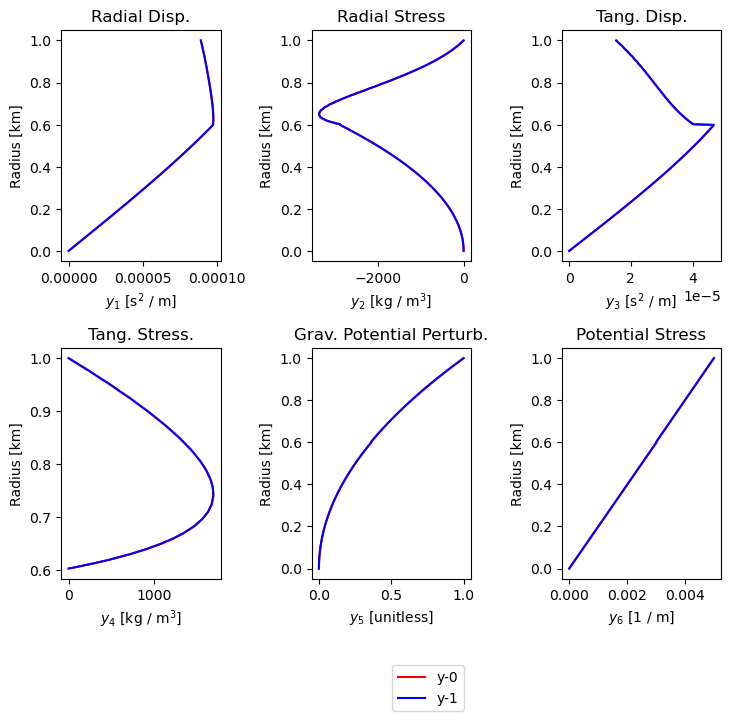

New RS (r=Dim; b=NoDim)


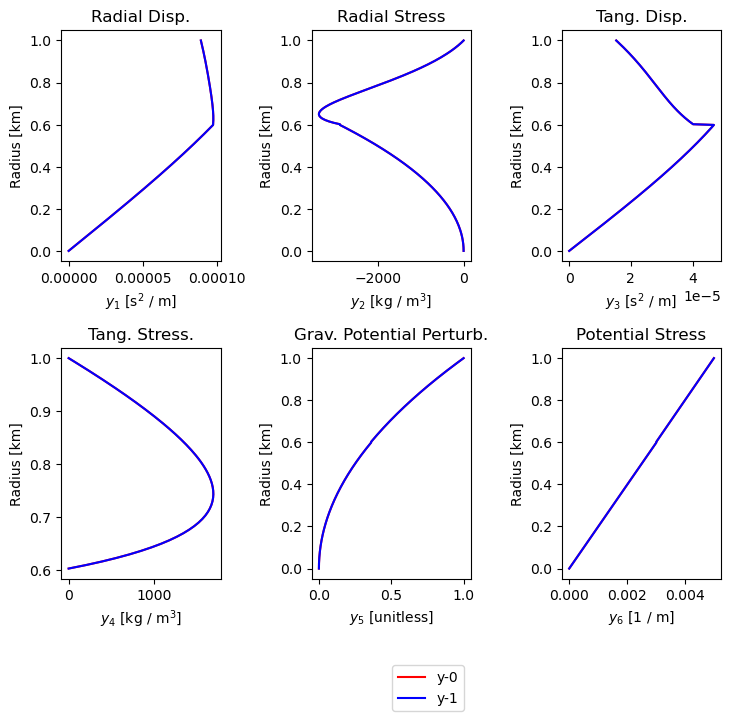

Dim (r=Old, b=New)


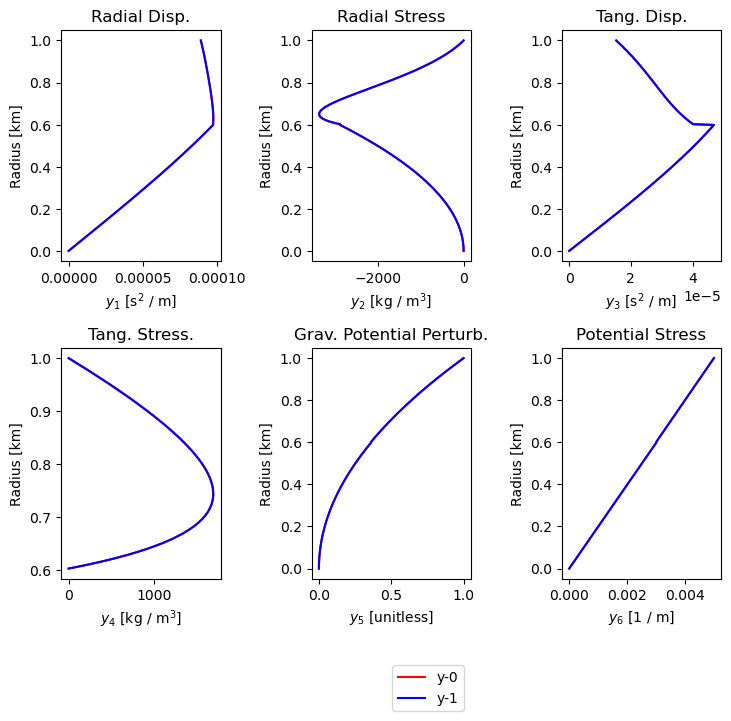

NoDim (r=Old, b=New)


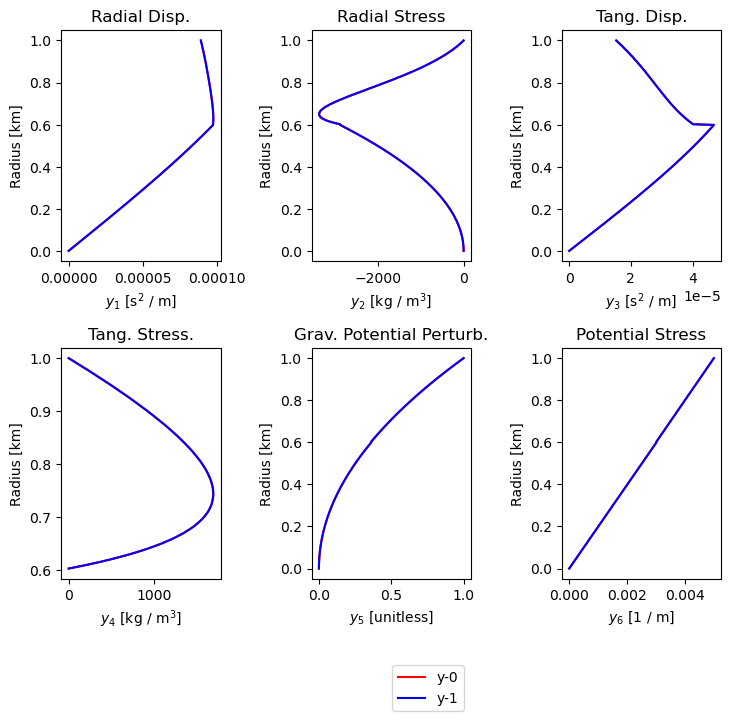

In [7]:
def test_3layer():
    layer_types = ('solid', 'liquid', 'solid')
    is_solid_by_layer = (True, False, True)
    is_static_by_layer = (False, False, False)
    integration_method = 'RK45'
    integration_rtol = 1.0e-8
    integration_atol = 1.0e-10
    nondimensionalize = True
    is_incompressible_by_layer = (False, False, False)
    use_kamata = False
    
    radius_array = np.linspace(0.1, 6000.0e3, 100)
    ICB_radius = 0.15 * radius_array[-1]
    CMB_radius = 0.45 * radius_array[-1]
    upper_radius_by_layer = (ICB_radius, CMB_radius, radius_array[-1])
    
    frequency = np.pi * 2. / (86400. * 0.5)
    
    ic_index = radius_array <= ICB_radius
    oc_index = np.logical_and(radius_array > ICB_radius, radius_array <= CMB_radius)
    mantle_index = radius_array > CMB_radius
    
    indices_by_layer = (ic_index, mantle_index)
    density_array = np.ones_like(radius_array) * 3500.
    density_array[ic_index] = 9600.
    density_array[oc_index] = 8000.
    
    planet_bulk_density = np.average(density_array)
    
    bulk_modulus_array = np.ones_like(radius_array) * 1.0e11
    bulk_modulus_array[ic_index] = 10.0e11
    bulk_modulus_array[oc_index] = 5.0e11
    shear_array = np.ones_like(radius_array) * 50.0e9
    shear_array[ic_index] = 150.0e9
    shear_array[oc_index] = 0.
    viscosity_array = np.ones_like(radius_array) * 1.0e18
    viscosity_array[ic_index] = 1.0e27
    viscosity_array[oc_index] = 1000.

    rheo_inst = Andrade()
    complex_shear_modulus_array = np.empty(radius_array.size, dtype=np.complex128)
    rheo_inst.vectorize_modulus_viscosity(frequency, shear_array, viscosity_array, complex_shear_modulus_array)
    
    volume_array, mass_array, gravity_array = \
        calculate_mass_gravity_arrays(radius_array, density_array)
    
    input_new_dict = dict(
        radius_array=radius_array,
        density_array=density_array,
        gravity_array=gravity_array,
        bulk_modulus_array=bulk_modulus_array,
        complex_shear_modulus_array=complex_shear_modulus_array,
        frequency=frequency,
        planet_bulk_density=planet_bulk_density,
        layer_types=layer_types,
        is_static_by_layer=is_static_by_layer,
        is_incompressible_by_layer=is_incompressible_by_layer,
        upper_radius_by_layer=upper_radius_by_layer,
        degree_l = 2,
        solve_for = None,
        use_kamata = use_kamata,
        integration_method = integration_method,
        integration_rtol = integration_rtol,
        integration_atol = integration_atol,
        scale_rtols_by_layer_type = False,
        max_num_steps = 5_000_000,
        expected_size = 1000,
        max_ram_MB = 3000,
        max_step = 0,
        limit_solution_to_radius = True,
        nondimensionalize = nondimensionalize,
        verbose = False,
        raise_on_fail = False,     
    )

    input_old_dict = dict(        
        radius=radius_array,
        density=density_array,
        gravity=gravity_array,
        bulk_modulus=bulk_modulus_array,
        shear_modulus=complex_shear_modulus_array,
        frequency=frequency,
        planet_bulk_density=planet_bulk_density,
        is_solid_by_layer=is_solid_by_layer,
        is_static_by_layer=is_static_by_layer,
        indices_by_layer=indices_by_layer,
        order_l = 2,
        surface_boundary_condition=None, 
        solve_load_numbers=False,
        use_kamata = use_kamata,
        integration_method = integration_method,
        integrator = 'cyrk',
        integration_rtol = integration_rtol,
        integration_atol = integration_atol,
        nondimensionalize = nondimensionalize,
        verbose = False,
        incompressible = False,        
    )

    new_result = radial_solver_new(**input_new_dict)
    old_ys = radial_solver_old(**input_old_dict)

    new_ys = new_result.result

    print(f'Old size: {old_ys.shape}; new: {new_ys.shape}.')
    yplot([old_ys, new_ys], [radius_array, radius_array], colors=['r', 'b'])
    
    percent_diff = 200 * np.abs(old_ys - new_ys) / (old_ys + new_ys)
    percent_diff[np.logical_and(np.isclose(old_ys, 0. + 0.j), np.isclose(new_ys, 0. + 0.j))] = np.nan
    yplot([percent_diff], [radius_array])

    print(new_ys[1, -1])

test_3layer()